In [1]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline



hierarchical clustering post:  
https://stats.stackexchange.com/questions/63546/comparing-hierarchical-clustering-dendrograms-obtained-by-different-distances/63549#63549

http://www.sthda.com/english/wiki/print.php?id=237

http://www.sthda.com/english/articles/26-clustering-basics/86-clustering-distance-measures-essentials/

in general, you should choose distance measure and linkage methods (single:nearest, complete:farest, ward: minimal increase of sum-of-squares, etc.) consciously, make sense. not blind trying. 

The distance should reflect the aspects of difference you are interested in, and the method - one must be aware - implies a specific archetype of a cluster

the metaphor of a Ward cluster is, I would say, type; 
cluster after complete linkage would be circle [by hobby or plot]; 
cluster after single linkage would be spectrum [chain]; 
cluster after centroid method would be proximity of platforms [politics]; 
an average linkage cluster is conceptually most undifferentiated and would be generally united class





In [110]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/chipseq_meta.txt'
df_meta = pd.read_csv(of)
# # drop the 2 hypermutated cases
# df_meta = df_meta[~df_meta.patient.isin(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'])]
assert df_meta.shape[0] == 35
df_meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology,strelka_mutations,HPV_status
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno,2958282,Negative
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno,1252217,Negative


In [111]:
category_track = df_meta[['patient', 'HIV_status', 'Putative_histology', 'HPV_status']]
numeric_track = df_meta[['patient', 'strelka_mutations', ]]
numeric_track['log_strelka_mutations'] = np.log10(numeric_track['strelka_mutations'])
numeric_track = numeric_track.drop('strelka_mutations', axis=1)
numeric_track.head(2)

/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,patient,log_strelka_mutations
0,HTMCP-03-06-02007,6.47104
1,HTMCP-03-06-02026,6.09768


read in Alessia's epigenetic gene categorization file

In [112]:
f4 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/categorisation_of_epigentic_modifiers_from_Alessia_v3.xls'
df4 = pd.read_excel(f4, sheetname='categorisation')
df41 = df4[['HIV neg', 'Category_1', 'Category_2']].set_index('HIV neg')
df5 = pd.read_excel(f4, sheetname='sample_mut_details_sz', index_col='patient')
df51 = df5[df5.columns[1:]].T
df6 = pd.merge(df51, df41, left_index=True, right_index=True)
df6.head(2)

,HTMCP-03-06-02007,HTMCP-03-06-02026,HTMCP-03-06-02063,HTMCP-03-06-02214,HTMCP-03-06-02042,HTMCP-03-06-02332,HTMCP-03-06-02185,HTMCP-03-06-02012,HTMCP-03-06-02196,HTMCP-03-06-02203,...,HTMCP-03-06-02230,HTMCP-03-06-02170,HTMCP-03-06-02152,HTMCP-03-06-02235,HTMCP-03-06-02195,HTMCP-03-06-02261,HTMCP-03-06-02147,HTMCP-03-06-02267,Category_1,Category_2
ARID1A,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Remodeller,SWI/SNF remodeling complex
ATRX,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Remodeller,SWI/SNF family


In [113]:
def categorize_cols(df, col):
    col_values = df[col].unique()
    lst = []
    for col_value in col_values:
        s = df.query('{0} == "{1}"'.format(col, col_value)).sum()
        lst.append(s)
    dfo = pd.DataFrame(lst)
    dfo.index = col_values
    dfo = dfo.drop([col], axis=1)
    return dfo

In [114]:
df8 = categorize_cols(df6, 'Category_1').drop('Category_2', axis=1)
df9 = categorize_cols(df6, 'Category_2').drop('Category_1', axis=1)
df10 = pd.concat([df8, df9]).reset_index().dropna().set_index('index').astype(float)
df10.head(2)

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02042,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP.03.06.02037,HTMCP.03.06.02046,HTMCP.03.06.02150,HTMCP.03.06.02174
index,,,,,,,,,,,,,,,,,,,,,
Remodeller,0.0,0.0,2.0,16.0,1.0,1.0,9.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Reader,1.0,0.0,0.0,21.0,1.0,1.0,7.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [115]:
df10[df10 < 0.5] = np.nan
df10[df10 > 0.5] = 'Positive'
df10.fillna('Negative', inplace=True)
df11 = df10.T
df11.head(2)

index,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,ISWI remdelling complexes,SEC (Super Elongation) Complex,INO80/SWR remodelling complexes,Testis-specific chromatin protein,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
HTMCP-03-06-02001,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive,Negative,...,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Positive
HTMCP-03-06-02002,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative


In [116]:
category_track = pd.merge(category_track, df11, left_on='patient', right_index=True, how='left')
category_track.head(2)

,patient,HIV_status,Putative_histology,HPV_status,Remodeller,Reader,Writer,Eraser,SWI/SNF remodeling complex,SWI/SNF family,...,ISWI chromatin remdelling,HAT complexes,NuRD complex,compass complex,HDAC complex,GNAT family HAT complexes,MYST family HAT complexes,RNF20/40 complex,SWI/SNF remodeling complex,TFIID basal transcription factor complex or PCAF histone acetylase complex
0,HTMCP-03-06-02007,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
1,HTMCP-03-06-02026,Negative,Adeno,Negative,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Negative,Positive


process chipseq signals

In [57]:
def get_files(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f,header=None)
    df.columns = ['file']
    df.head(2)
    return df


In [58]:
def integrate_signals(f):
#     f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'gene', 'chip_chr', 'chip_start', 'chip_end', 'peak_height']
    df['area'] = df.peak_height * (df.chip_end - df.chip_start)
    dfg = df.groupby(['chr', 'start', 'end', 'gene'])['area'].sum().reset_index()
    of = '{0}.{1}'.format(f, 'sum')
    dfg.to_csv(of, index=False)

In [59]:

def process_signals(df1):
#     f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/treat_pileup_files.txt' 
    for idx, f in df1.iterrows():
        f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/{}'.format(f['file'])
        integrate_signals(f)

In [60]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/pileup_files/treat_intersected_files.txt'
df1 = get_files(f1)

In [68]:
df1.shape

(210, 1)

In [60]:
# process_signals(df1)

In [61]:
marks = ["H3K4me1",
"H3K4me3",
"H3K9me3",
"H3K27me3",
"H3K36me3",
"H3K27ac"
]

In [37]:
# df1.file.str.contains('H3K4me3')

In [62]:
def merge_data(df):
    dfm = pd.DataFrame()
    for idx, f in df.iterrows():
        f1 = '{0}/{1}/{2}.sum'.format(wkdir, 'pileup_files', f['file'])
#         library = '_'.join(f['file_y'].split('_')[2:5])
        library = f['file'].split('_')[2]
        df1 = pd.read_csv(f1).set_index(['chr', 'start', 'end', 'gene'])
        df1.columns = [library]
        if dfm.empty:
            dfm = df1.copy()
        else:
            dfm = pd.merge(dfm, df1, left_index=True, right_index=True)
    return dfm
 

unsupervised clustering based on mean promoter H3K4me3 signal

heatmap to visualize the data

In [73]:
# cmap = sns.light_palette('red', as_cmap=True)
# g = sns.clustermap(dfm2, cmap = cmap)
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# pass

In [72]:
def make_dendrogram(dfmm2, mark):
#     dfmm2 = dfm.copy()
    np.isnan(dfmm2.values).any()
    np.isinf(dfmm2.values).any()

    # cluster by promoter signals so the array needs to be [number of patients, number of features]
    matrix = dfmm2.values.T
    matrix

    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)

    fig, ax = plt.subplots(figsize=(12,6))
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfmm2.columns,leaf_font_size=12.,show_contracted=True)#
#     plt.suptitle('unsupervised_clustering_{}_bdg_mean'.format, fontsize=14)  
    plt.title('unsupervised_clustering_{}_bdg_mean'.format, fontsize=14)
    plt.tight_layout()
    of = '{0}unsupervised_clustering_{1}_bdg_mean.png'.format(wkdir, mark)
    plt.savefig(of, dpi=200, box_inches='tight')

In [74]:
# df_track.head()

In [81]:
# def get_track_df(dfm2, df_meta):
#     # get labels of the dendrogram and make track data frame
#     # cluster by promoter signals so the array needs to be [number of patients, number of features]
#     matrix = dfm2.values.T
#     dist='correlation'
#     link='ward'
#     Z = linkage(pdist(matrix, dist), link)
#     aa = dendrogram(Z, leaf_rotation=90.,labels = dfm2.columns,leaf_font_size=12.,show_contracted=True)
#     den_labels = aa['ivl']
#     adf = pd.DataFrame(den_labels)
#     adf.columns = ['patient']
#     df_track = pd.merge(adf, df_meta[['patient', 'HIV_status', 'Putative_histology' ]], left_on='patient', right_on='patient')#.drop(0, axis=1)
#     df_track = df_track.set_index('patient')
#     return (Z, df_track)

plot hiv and histology track

In [52]:
def map_features_to_colors(df_track, map_dict1, clrs):
#     clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
#     map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    map_dict2 = {}
    for n, k in enumerate(map_dict1.keys()):
        map_dict2[k] = clrs[n]
    assert list(map_dict2.values()) == clrs
    ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
#     legends = sorted(map_dict1, key=map_dict1.get, reverse=False)
    return (ndf_track, map_dict2)

In [123]:
def plot_cluster(numeric_track, category_track, dfm, mark, map_dict2): # df= tracks, dfm = histone mark signal df
#     df = ncategory_track.copy() # track df
    # dfm: histone mark signal df
    
    fig = plt.figure(figsize=(16, 8), facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[17,1], 
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )

    bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
    assert len(bounds) == len(map_dict1) + 1
    # make a color map of fixed colors
    cmap = colors.ListedColormap(clrs)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    nrow = len(category_track.index)
    ncol = len(category_track.columns)
    print(nrow, ncol)

    # left panel 3x1 for n_track, c_trak, and dendrogram
    gs01 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[.5, 14, 4], subplot_spec=gs[0],  hspace=0.0)
    
     # add dendrogram
    ax1_3 = fig.add_subplot(gs01[2])
    ax1_3.set_title("")
#     ax1_3 = fig.add_subplot(gs[4], facecolor='white')
    matrix = dfm.values.T
    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    c_track = pd.merge(adf, category_track.T, left_on='patient', right_index=True)#.drop(0, axis=1)
    c_track = c_track.set_index('patient')
    c_track = c_track.T
    plt.suptitle('unsupervised_clustering_{}_bdg_area_hm_excluded'.format(mark), fontsize=14)  
#     print(den_labels)
    

    
    
    # plot category track
    ax1_2 = fig.add_subplot(gs01[1], facecolor='white')
#     ax1_2.set_title("")
    print('category track shape is {}'.format(c_track.shape))
    img = ax1_2.imshow(c_track.values, interpolation='none', origin='upper', aspect='auto',
                        cmap=cmap, norm=norm)
    _ = plt.yticks(np.arange(0, nrow, 1), c_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), c_track.columns, fontsize=8, rotation=90)

    _ = ax1_2.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_2.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_2.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_2.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_2.spines['right'].set_visible(True)
    ax1_2.spines['top'].set_visible(True)
    ax1_2.set_xticklabels('')
#     print(c_track.columns)
    

    # plot numeric track
    ax1_1 = fig.add_subplot(gs01[0], facecolor='white')
#     ax1_1.set_title("")
    numeric_track = numeric_track.set_index('patient').astype(float)
    n_track = pd.merge(adf, numeric_track, left_on='patient', right_index=True)#.drop(0, axis=1)
    n_track = n_track.set_index('patient')
    n_track = n_track.T
    nrow = len(n_track.index)
    ncol = len(n_track.columns)
    print('numeric track has {0} rows and {1} columns'.format(nrow, ncol))
    img1_1 = ax1_1.imshow(n_track.values, interpolation='none', origin='upper', aspect='auto', cmap='Reds')
    _ = plt.yticks(np.arange(0, nrow, 1), n_track.index, fontsize=8)
    _ = plt.xticks(np.arange(0, ncol, 1), n_track.columns, fontsize=8, rotation=90)

    _ = ax1_1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
    _ = ax1_1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

    # Gridlines based on minor ticks
    _ = ax1_1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
    # hide major tick grid
    _ = ax1_1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

    ax1_1.spines['right'].set_visible(True)
    ax1_1.spines['top'].set_visible(True)
    ax1_1.set_xticklabels('')
#     print(n_track.columns)

    

    # right panel 2x1 for lengends, colorbar and rectangles
    gs02 = gridspec.GridSpecFromSubplotSpec(2, 1,  height_ratios=[1, 1], subplot_spec=gs[1])
    
    # color bar for numeric_track 
    ax2_1 = fig.add_subplot(gs02[0], facecolor='white')
    ax2_1.set_title("mutations_log10")
        
    _ = plt.colorbar(img1_1, cax=ax2_1, orientation= 'vertical', label='')#, aspect=40) 

    
    # add retangle legend for category track
    ax2_2 = fig.add_subplot(gs02[1], facecolor='white')
    ax2_2.set_title("rectangles")
        
#     ax6 = fig.add_subplot(gs[5], facecolor='white')
    # plot mutation legend
    k = 1
    for key in map_dict2:
        if key !=0: # don't plot key=0 which means no mutation
            clr = map_dict2[key]
            rect = patches.Rectangle((0,k/7), 0.3, 0.1, linewidth=0.01,edgecolor=clr,facecolor=clr)
            _ = ax2_2.text(0.35, k/7+.07, key, ha='left', va='center', fontsize=8)
            _ = ax2_2.add_patch(rect)
        k+=1
    ax2_2.get_xaxis().set_ticks([])
    ax2_2.get_yaxis().set_ticks([])

    ax2_2.set_title('')

  
    
    # make sure columns in numeric, category, and dendrogram match
#     print(den_labels)
#     print(c_track.columns.tolist())
    assert den_labels == c_track.columns.tolist()
    assert den_labels == n_track.columns.tolist()
#     plt.tight_layout()
    


    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_{}_bdg_area_hypermutated_excluded.png'.format(mark)
    %time plt.savefig(of, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [117]:
category_track = category_track[~category_track.patient.isin(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'])]

In [119]:
category_track.shape

(33, 28)

In [97]:
numeric_track.head()

,patient,log_strelka_mutations
2,HTMCP-03-06-02063,5.254096
3,HTMCP-03-06-02214,5.021694
4,HTMCP-03-06-02042,4.527269
5,HTMCP-03-06-02332,4.356217
6,HTMCP-03-06-02185,4.781382


In [88]:
numeric_track = numeric_track[~numeric_track.patient.isin(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'])]

In [74]:
marks

['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K27ac']

merging signal for mark: H3K4me1
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.48 s, sys: 144 ms, total: 4.63 s
Wall time: 4.63 s


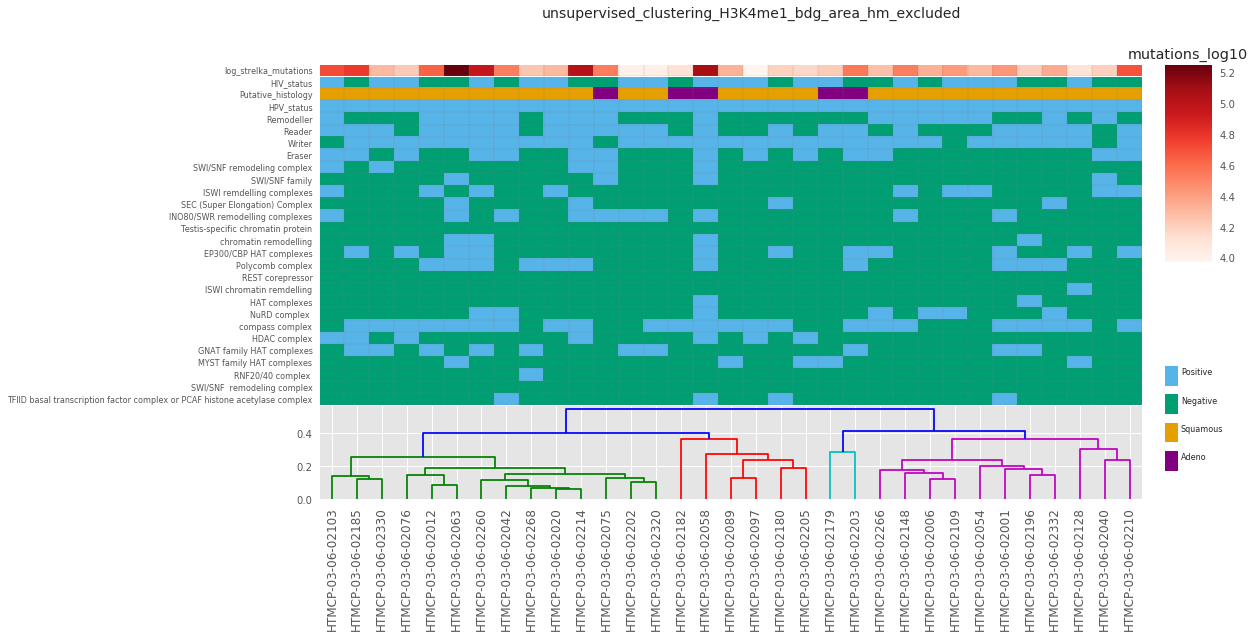

merging signal for mark: H3K4me3
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.51 s, sys: 133 ms, total: 4.65 s
Wall time: 4.65 s


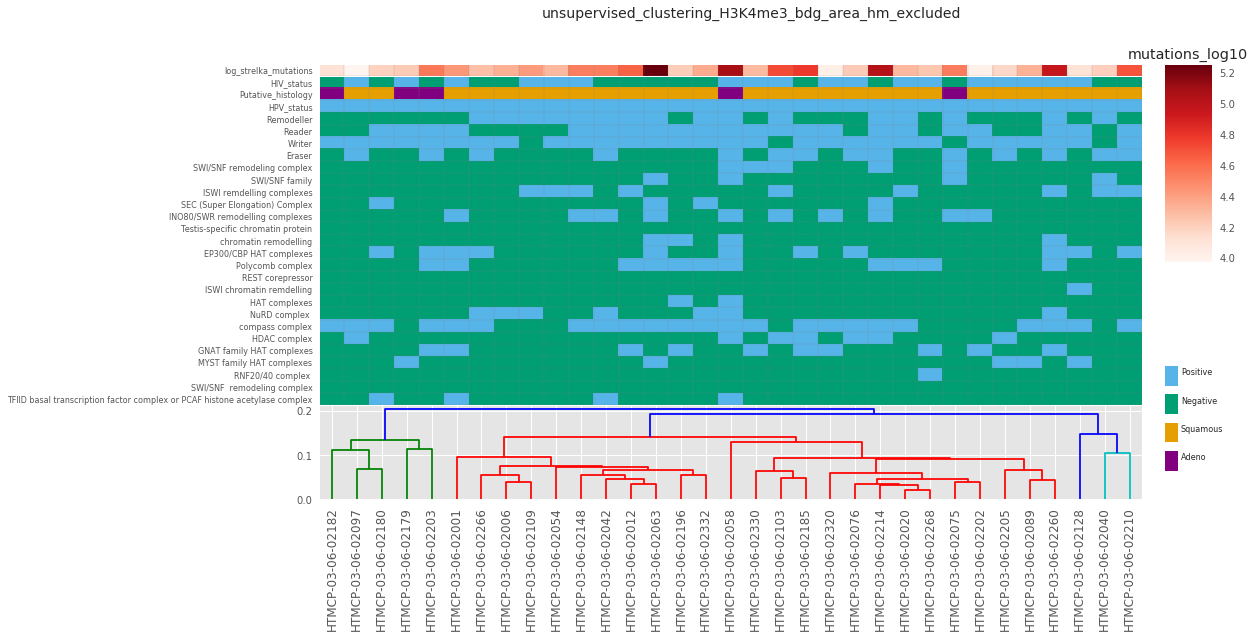

merging signal for mark: H3K9me3
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.5 s, sys: 133 ms, total: 4.63 s
Wall time: 4.63 s


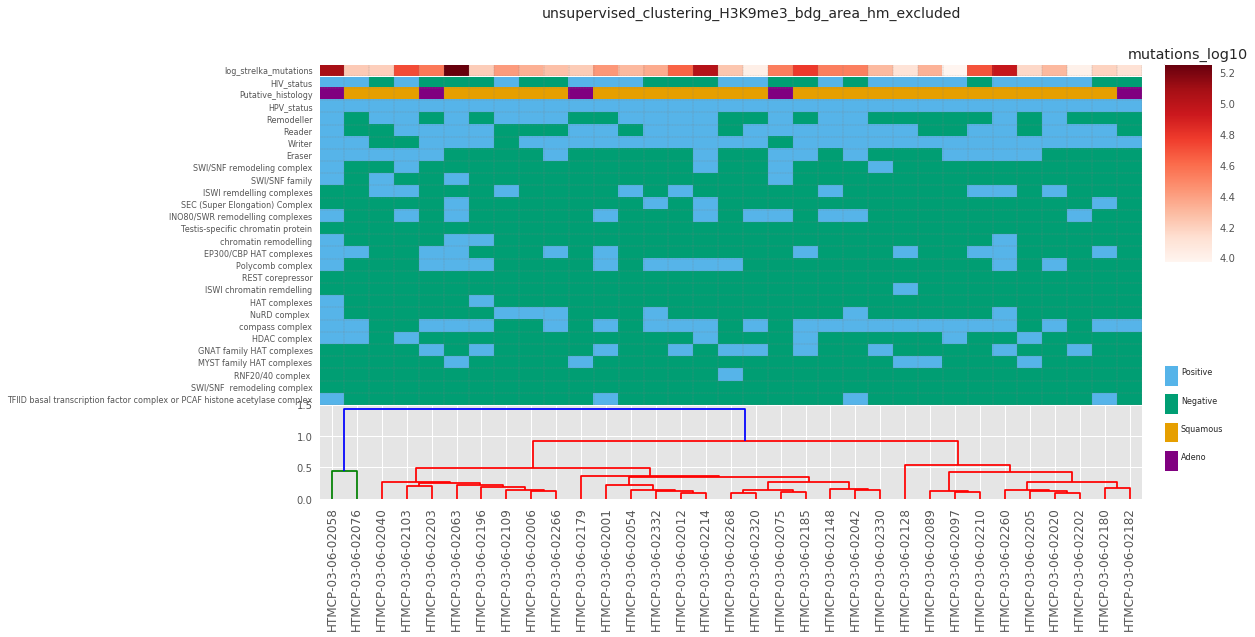

merging signal for mark: H3K27me3
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.58 s, sys: 111 ms, total: 4.69 s
Wall time: 4.69 s


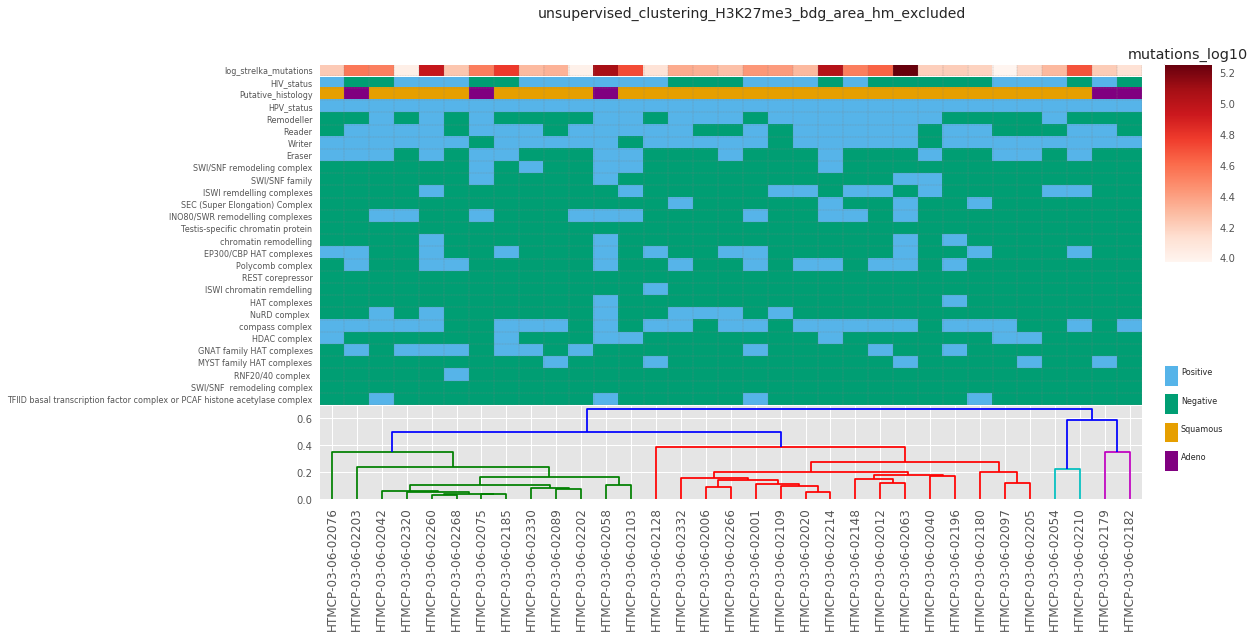

merging signal for mark: H3K36me3
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.56 s, sys: 114 ms, total: 4.68 s
Wall time: 4.68 s


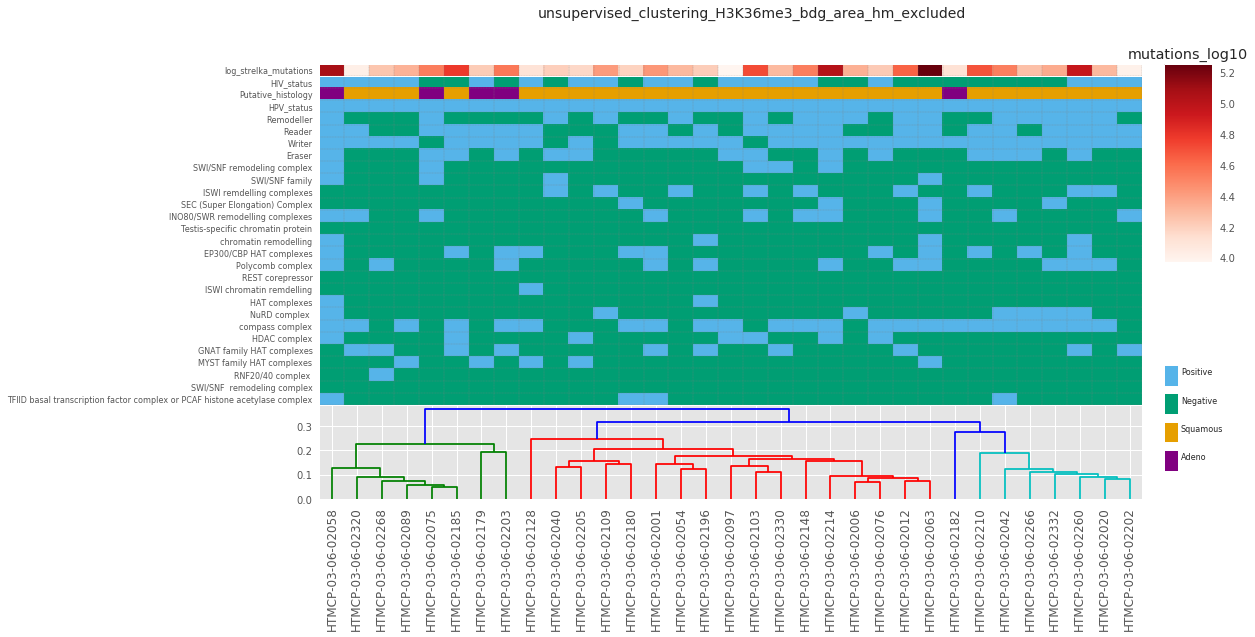

merging signal for mark: H3K27ac
(33, 27)
27 33
category track shape is (27, 33)
numeric track has 1 rows and 33 columns


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.8 s, sys: 120 ms, total: 4.92 s
Wall time: 4.92 s


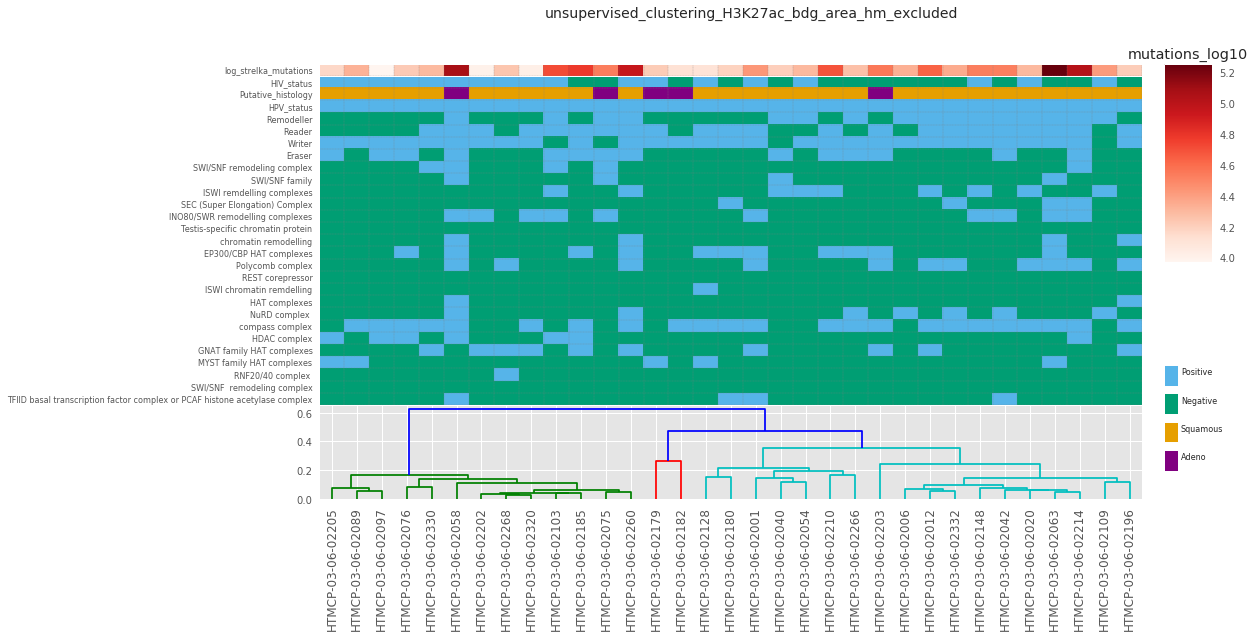

In [124]:
for mark in marks:
    print('merging signal for mark: {}'.format(mark))
    df_mark = df1[df1['file'].str.contains(mark)]
    dfm_mark = merge_data(df_mark)
    dfm_mark = dfm_mark/4000 # length of the promoter regaionx
    lib_name = '{} library ID'.format(mark)
    df_meta1 = df_meta[[lib_name, 'patient']].set_index(lib_name)
    d = df_meta1.to_dict()
    dfm_mark.columns = dfm_mark.columns.to_series().map(d['patient'])
#     drop 2 hypermutated cases
    dfm_mark = dfm_mark.drop(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'], axis=1)
    assert dfm_mark.shape[1] == 33
    print(cat_track.shape)
    cat_track = category_track.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
    plot_cluster(numeric_track, ncategory_track, dfm_mark, mark, map_dict2)



In [75]:
dfm_mark.head()

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613            8.47525           6.032250   
     67092  71091  ENSG00000186092            2.48200           2.490629   
     365641 369640 ENSG00000235249            1.55100           1.059451   
     620053 624052 ENSG00000185097            1.59250           1.559568   
     858261 862260 ENSG00000187634            4.57125           7.355193   

                                    HTMCP-03-06-02012  HTMCP-03-06-02020  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613           3.530557            2.88650   
     67092  71091  ENSG00000186092           1.013290            2.20675   
     365641 369640 ENSG00000235249           0.878247            1.23550   
     620053 624052 ENSG00000185097           1.135154            1.03400   
     858261 862260 ENSG00000187634           5.739812            4.29400   

                                    HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613            4.74850            2.56600   
     67092  71091  ENSG00000186092            1.34175            1.98900   
     365641 369640 ENSG00000235249            4.85025            0.79300   
     620053 624052 ENSG00000185097            5.79150            0.77400   
     858261 862260 ENSG00000187634            2.66800            4.88825   

                                    HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613            9.41750            6.45225   
     67092  71091  ENSG00000186092            1.10000            1.57225   
     365641 369640 ENSG00000235249            0.71100            0.66625   
     620053 624052 ENSG00000185097            1.32600            1.04325   
     858261 862260 ENSG00000187634            4.97175            1.83250   

                                    HTMCP-03-06-02109  HTMCP-03-06-02063  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613           7.733035            3.51950   
     67092  71091  ENSG00000186092           1.245624            1.57875   
     365641 369640 ENSG00000235249           2.821185            0.70400   
     620053 624052 ENSG00000185097           4.225455            1.09600   
     858261 862260 ENSG00000187634           4.354853            5.85800   

                                          ...          HTMCP-03-06-02210  \
chr  start  end    gene                   ...                              
chr1 34081  38080  ENSG00000237613        ...                   5.716868   
     67092  71091  ENSG00000186092        ...                   4.918650   
     365641 369640 ENSG00000235249        ...                   1.420900   
     620053 624052 ENSG00000185097        ...                   1.424620   
     858261 862260 ENSG00000187634        ...                   4.684242   

                                    HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613            2.80700           5.144872   
     67092  71091  ENSG00000186092            1.23000           1.058789   
     365641 369640 ENSG00000235249            1.35025           0.308928   
     620053 624052 ENSG00000185097            1.52625           0.675523   
     858261 862260 ENSG00000187634            3.96725           4.012529   

                                    HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start  end    gene                                                    
chr1 34081  38080  ENSG00000237613           2.703752            3.38375   
     67092  71091  ENSG00000186092           3.568194            1.71675   
 

merging signal for mark: H3K4me1
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.55 s, sys: 5.01 s, total: 8.56 s
Wall time: 12.3 s


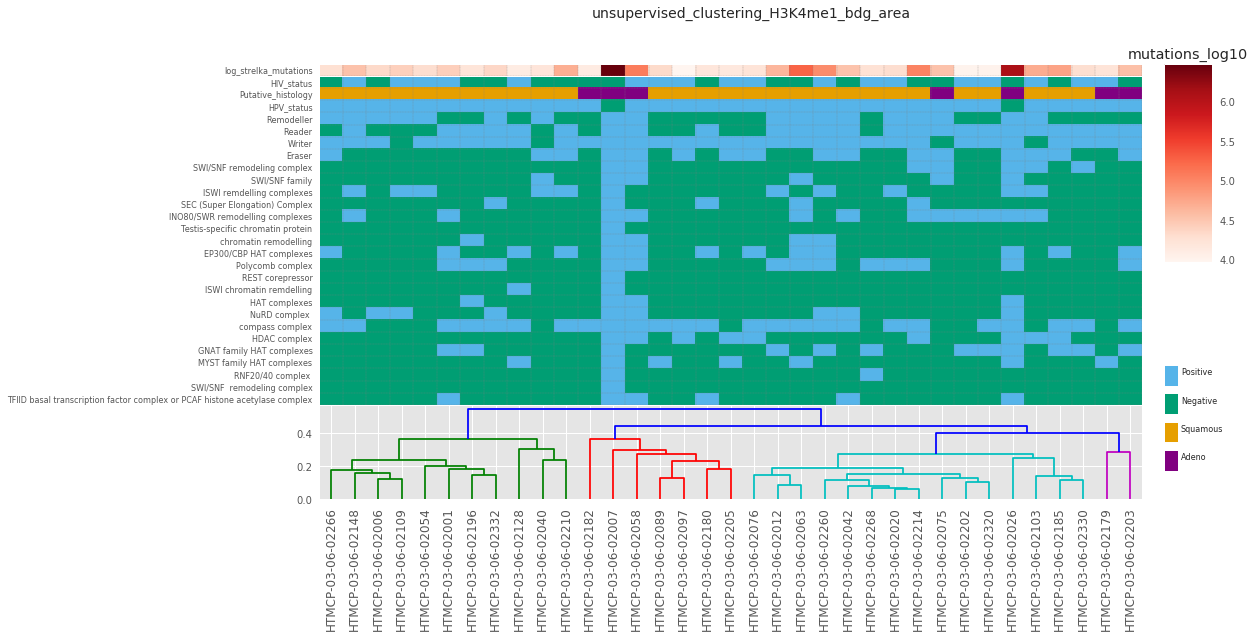

merging signal for mark: H3K4me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.06 s, sys: 3.04 s, total: 6.1 s
Wall time: 7.89 s


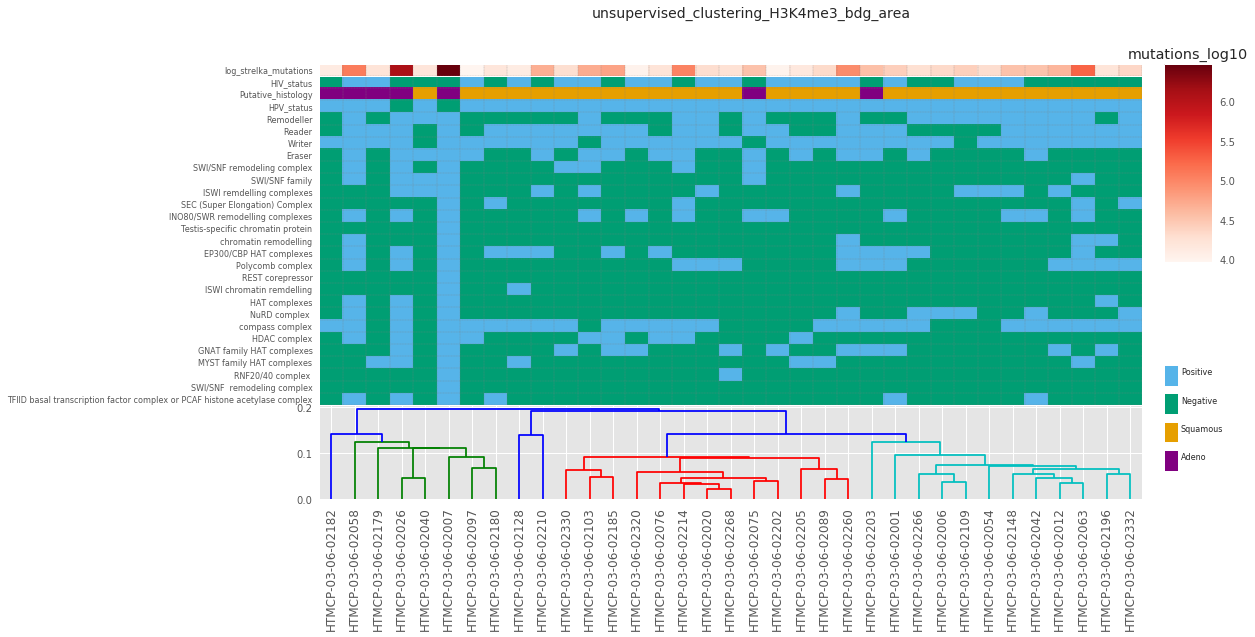

merging signal for mark: H3K9me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.14 s, sys: 2.62 s, total: 6.76 s
Wall time: 6.76 s


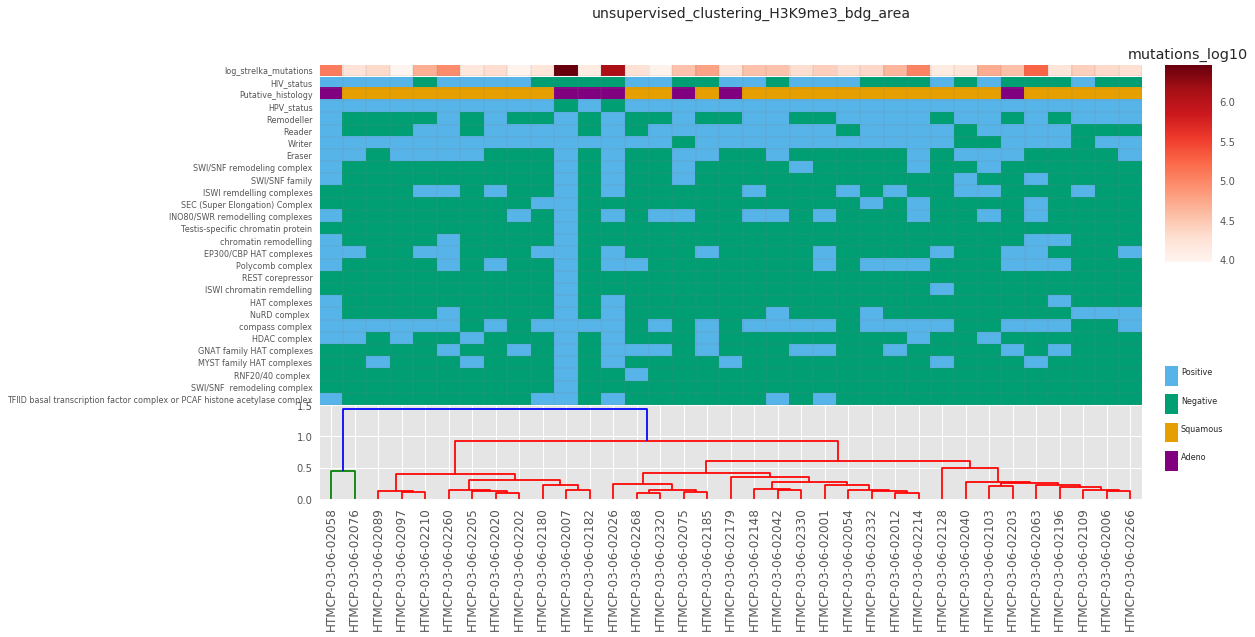

merging signal for mark: H3K27me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.17 s, sys: 12.3 s, total: 15.5 s
Wall time: 29.1 s


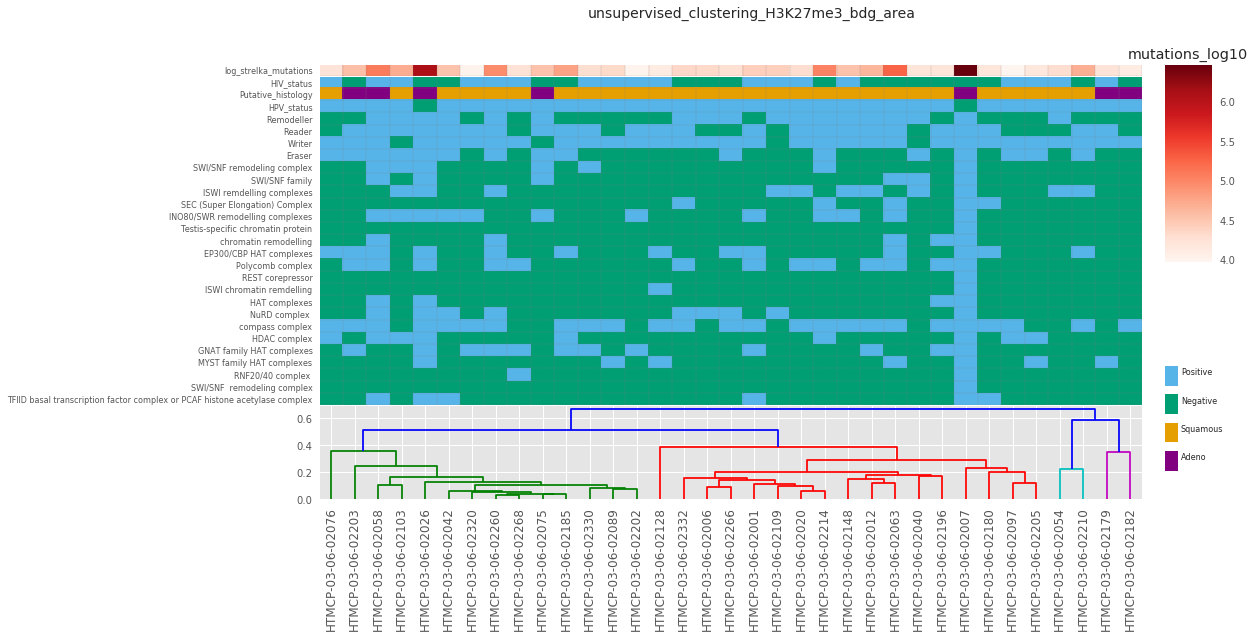

merging signal for mark: H3K36me3
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 4.61 s, sys: 3.99 s, total: 8.6 s
Wall time: 8.74 s


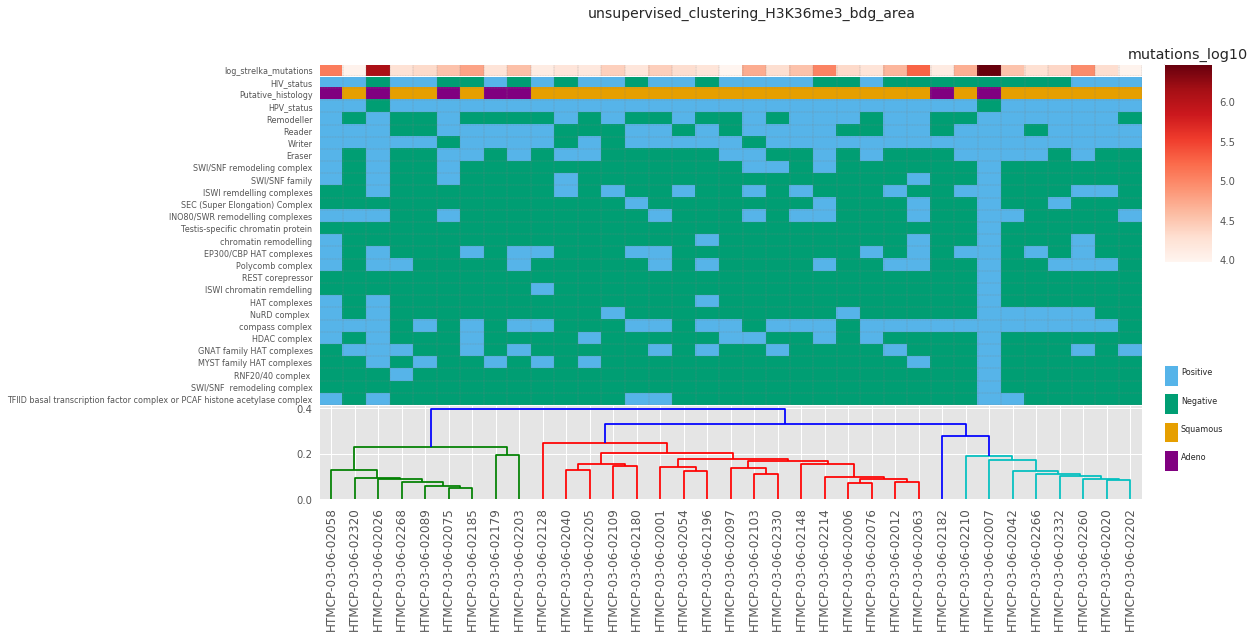

merging signal for mark: H3K27ac
27 35
1 35


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 3.68 s, sys: 7.94 s, total: 11.6 s
Wall time: 21.8 s


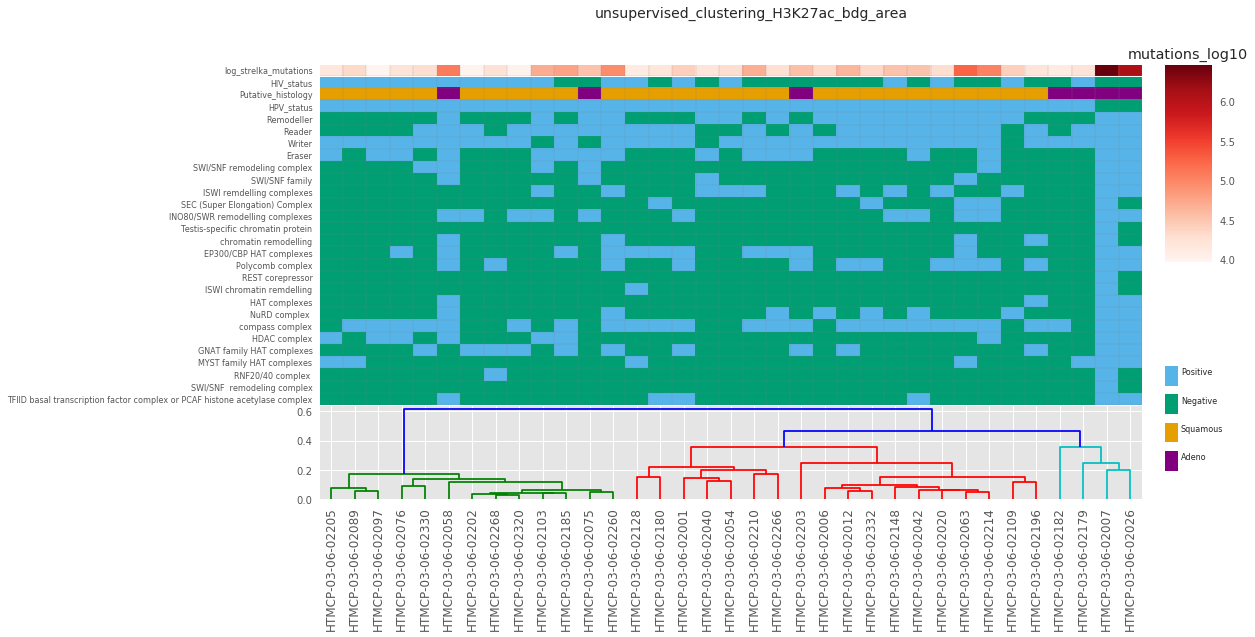

In [94]:
for mark in marks:
    print('merging signal for mark: {}'.format(mark))
    df_mark = df1[df1['file'].str.contains(mark)]
    dfm_mark = merge_data(df_mark)
    dfm_mark = dfm_mark/4000 # length of the promoter regaionx
    lib_name = '{} library ID'.format(mark)
    df_meta1 = df_meta[[lib_name, 'patient']].set_index(lib_name)
    d = df_meta1.to_dict()
    dfm_mark.columns = dfm_mark.columns.to_series().map(d['patient'])
    cat_track = category_track.set_index('patient')
    clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]
    map_dict1 =  {'Adeno': 0.15,'Squamous': 0.25, 'Negative': 0.35, 'Positive': 0.45}
    ncategory_track, map_dict2 = map_features_to_colors(cat_track, map_dict1, clrs)
    plot_cluster(numeric_track, ncategory_track, dfm_mark, mark, map_dict2)


In [96]:
dfm_mark.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            4.76600            1.86050   
     67092 71091 ENSG00000186092            2.35975            1.00375   

                                  HTMCP-03-06-02007  HTMCP-03-06-02012  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            1.43025              1.100   
     67092 71091 ENSG00000186092            1.53500              0.381   

                                  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            2.93675            0.62200   
     67092 71091 ENSG00000186092            2.02000            0.30275   

                                  HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            2.84000            2.66825   
     67092 71091 ENSG00000186092            1.16075            2.09950   

                                  HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            4.26975            3.34125   
     67092 71091 ENSG00000186092            0.85525            0.20625   

                                        ...          HTMCP-03-06-02210  \
chr  start end   gene                   ...                              
chr1 34081 38080 ENSG00000237613        ...                    2.12025   
     67092 71091 ENSG00000186092        ...                    2.62850   

                                  HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            1.65675           7.565425   
     67092 71091 ENSG00000186092            0.45250           0.657195   

                                  HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613           3.427028            2.27375   
     67092 71091 ENSG00000186092           2.771102            1.25550   

                                  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613           6.742949               2.04   
     67092 71091 ENSG00000186092           2.689243               0.28   

                                  HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613             1.1745             0.9500   
     67092 71091 ENSG00000186092             0.4050             0.4525   

                                  HTMCP-03-06-02332  
chr  start end   gene                                
chr1 34081 38080 ENSG00000237613           2.861793  
     67092 71091 ENSG00000186092           1.286153  

[2 rows x 35 columns]

In [100]:
matplotlib.is_interactive()

True

In [236]:
df32 = pd.DataFrame(df3.file_y)
dfm2 = merge_data(df32)
dfm2 = dfm2/4000 # length of the promoter regaion
dfm2.head()

A84611_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.427685   
     67092  71091  ENSG00000186092                0.061214   
     365641 369640 ENSG00000235249                0.041954   
     620053 624052 ENSG00000185097                0.043833   
     858261 862260 ENSG00000187634                0.559055   

                                    A84618_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.310419   
     67092  71091  ENSG00000186092                0.055682   
     365641 369640 ENSG00000235249                0.009753   
     620053 624052 ENSG00000185097                0.019739   
     858261 862260 ENSG00000187634                0.287142   

                                    A84625_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.252474   
     67092  71091  ENSG00000186092                0.113265   
     365641 369640 ENSG00000235249                0.007909   
     620053 624052 ENSG00000185097                0.003780   
     858261 862260 ENSG00000187634                0.111270   

                                    A84632_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.204968   
     67092  71091  ENSG00000186092                0.049366   
     365641 369640 ENSG00000235249                0.034107   
     620053 624052 ENSG00000185097                0.044374   
     858261 862260 ENSG00000187634                0.226632   

                                    A84639_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.228736   
     67092  71091  ENSG00000186092                0.203678   
     365641 369640 ENSG00000235249                0.041958   
     620053 624052 ENSG00000185097                0.027462   
     858261 862260 ENSG00000187634                0.014630   

                                    A84646_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.146941   
     67092  71091  ENSG00000186092                0.133603   
     365641 369640 ENSG00000235249                0.016568   
     620053 624052 ENSG00000185097                0.020352   
     858261 862260 ENSG00000187634                0.094569   

                                    A84653_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.130224   
     67092  71091  ENSG00000186092                0.105407   
     365641 369640 ENSG00000235249                0.022140   
     620053 624052 ENSG00000185097                0.058604   
     858261 862260 ENSG00000187634                0.020124   

                                    A84660_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.237918   
     67092  71091  ENSG00000186092                0.316299   
     365641 369640 ENSG00000235249                0.013750   
     620053 624052 ENSG00000185097                0.044327   
     858261 862260 ENSG00000187634                0.032539   

                                    A84667_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.352411   
     67092  71091  ENSG00000186092                0.073475   
     365641 369640 ENSG00000235249                0.018340   
     620053 624052 ENSG00000185097                0.017215   
     858261 862260 ENSG00000187634                0.262516   

                                    A84674_H3K4me3_control  \
chr  start  end    gene                                    

# make input file for ChromHMM

In [2]:
f = '/home/szong/projects/META_2018/Master_Sample_table_14X292_Feb27_2018_sz.xls'
meta = pd.read_excel(f, sheetname='HTMCP CaCx epi')
meta.head(2)

,Order,Biospecimen ID,HIV status,Epigenome modifier mutation status,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,...,H3K4me3 % aligned,H3K9me3 % aligned,H3K27me3 % aligned,H3K36me3 % aligned,H3K27ac % aligned,input DNA control % aligned,internal sample ID,pool ID,Notes,# lanes 7 PE
0,1,HTMCP-03-06-02007-01A,negative,mutated,A84624,A84625,A84626,A84627,A84628,A84629,...,98.13,93.1,97.93,98.57,98.10,96.26,NaN,IX5978,NaN,1
1,2,HTMCP-03-06-02026-01A,negative,mutated,A84645,A84646,A84647,A84648,A84649,A84650,...,97.68,93.89,97.84,98.17,97.86,95.56,NaN,IX5981,NaN,1


In [3]:
meta.columns

Index(['Order', 'Biospecimen ID', 'HIV status',
       'Epigenome modifier mutation status', 'H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID',
       'input DNA control  library ID', ' Library construction status',
       'Sequencing status', 'H3K4me1 total reads', 'H3K4me3  total reads',
       'H3K9me3 total reads', 'H3K27me3 total reads', 'H3K36me3 total reads',
       'H3K27ac total reads', 'input DNA control  total reads',
       'H3K4me1 % aligned', 'H3K4me3  % aligned', 'H3K9me3 % aligned',
       'H3K27me3 % aligned', 'H3K36me3 % aligned', 'H3K27ac % aligned',
       'input DNA control   % aligned', 'internal sample ID', 'pool ID',
       'Notes', '# lanes 7 PE'],
      dtype='object')

In [4]:
meta.set_index('Biospecimen ID', inplace=True)

In [5]:
df = meta[['H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID', 'input DNA control  library ID']].stack().reset_index()

In [6]:
df.head(2)

,Biospecimen ID,level_1,0
0,HTMCP-03-06-02007-01A,H3K4me1 library ID,A84624
1,HTMCP-03-06-02007-01A,H3K4me3 library ID,A84625


In [7]:
df['marks'] = df.level_1.apply(lambda x: x.replace(' library ID', ''))
df['patient'] = df['Biospecimen ID'].apply(lambda x: x.replace('-01A', ''))
df.drop('Biospecimen ID', axis=1, inplace=True)

In [8]:
df = df.drop('level_1', axis=1)

In [9]:
df.head(2)

,0,marks,patient
0,A84624,H3K4me1,HTMCP-03-06-02007
1,A84625,H3K4me3,HTMCP-03-06-02007


In [100]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/libs.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [81]:
df['treat'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_treat_pileup.bdg'

In [82]:
df['control'] = 'sorted_UCSC_' + df[0] + '_' + df['marks'] + '_control_lambda.bdg'

In [83]:
df.head(2)

,0,marks,patient,treat,control
0,A84624,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,A84625,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [84]:
df = df.drop(0, axis=1)

In [85]:
df.head(2)

,marks,patient,treat,control
0,H3K4me1,HTMCP-03-06-02007,sorted_UCSC_A84624_H3K4me1_treat_pileup.bdg,sorted_UCSC_A84624_H3K4me1_control_lambda.bdg
1,H3K4me3,HTMCP-03-06-02007,sorted_UCSC_A84625_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84625_H3K4me3_control_lambda.bdg


In [87]:
cols = ['patient', 'marks', 'treat', 'control']

In [89]:
df = df[cols]

In [90]:
# f = '/projects/da_workspace/software/ChromHMM/Cervical/bed_files.txt'
# df.to_csv(f, sep='\t', index=False, header=False)

In [11]:
df1 = df.set_index(0)

In [12]:
df1.head(2)

,marks,patient
0,,
A84624,H3K4me1,HTMCP-03-06-02007
A84625,H3K4me3,HTMCP-03-06-02007


In [13]:
# fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
fbam = '/projects/da_workspace/software/ChromHMM/Cervical/bam_path_from_victoira.txt'
dfbam = pd.read_csv(fbam, sep='\t', header=None, index_col=0)
dfbam.head(2)

,1
0,
A84610,/projects/analysis/analysis30/IX5976/CC0TLANXX...
A84611,/projects/analysis/analysis30/IX5976/CC0TLANXX...


In [14]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/bam_files.txt'
dfm = pd.merge(df1, dfbam, left_index=True, right_index=True).set_index('patient', drop=True)
# dfm.to_csv(f, sep='\t', header=False)

In [17]:
dfm.marks.unique()

array(['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K27ac',
       'input DNA control '], dtype=object)

In [21]:
f = '/projects/da_workspace/software/ChromHMM/Cervical/control_bam_files.txt'
dfm[dfm.marks == 'input DNA control '].to_csv(f, sep='\t', header=False)

In [24]:
dfm[dfm[1].isnull()]

,marks,1
patient,,
